In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import meerkat as mk
import numpy as np
import torch.nn as nn
import torch
import seaborn as sns
from domino.slices.train import train_model

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [3]:
run_id = 4663
dataset_dp = train_model.inp(run_id)["dp"].load()
model = train_model.get_artifacts("best_chkpt", run_id)["model"]

In [4]:
test_dp = dataset_dp.lz[dataset_dp["split"] == "test"].lz[:5_000]

In [5]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=test_dp, 
    input_column="input",
    batch_size=128
)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [6]:
score_dp["loss"] = nn.functional.cross_entropy(score_dp["output"].data, torch.tensor(score_dp["target"].data), reduction="none")

In [7]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp["target"], score_dp["prob"])
))
print("Overall AUROC with correlate: {}".format(
    roc_auc_score(score_dp["correlate"], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] == score_dp["correlate"]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp["target"], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] != score_dp["correlate"]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp["target"], curr_dp["prob"])
))

Overall AUROC: 0.9615242018537591
Overall AUROC with correlate: 0.9123361711379004
AUROC where correlation holds: 0.9800565673289184
AUROC where correlation does not hold: 0.8504347826086956


In [8]:
from domino.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="object_image")

In [9]:
from domino.sdm import SpotlightSDM
sdm = SpotlightSDM(config={"emb": "emb", "min_weight": 30, "num_steps": 10000, "learning_rate": 1e-1})

out = sdm.fit(score_dp)

/home/sabri/code/domino/domino/sdm/spotlight.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(embeddings, device=device)
/home/sabri/code/domino/domino/sdm/spotlight.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(losses, device=device)


steps =   200 | ms =   771 | mean = 122.92 | precision = 0.003404 | loss = 0.099 | total weight =  4191.8 | barrier = 4229.6 | lr = 0.10000
steps =   400 | ms =  1455 | mean = 121.85 | precision = 0.006520 | loss = 0.103 | total weight =  3574.4 | barrier = 3596.5 | lr = 0.10000
steps =   600 | ms =  2133 | mean = 121.44 | precision = 0.009683 | loss = 0.108 | total weight =  3043.4 | barrier = 3058.2 | lr = 0.10000
steps =   800 | ms =  2816 | mean = 122.04 | precision = 0.012728 | loss = 0.112 | total weight =  2589.8 | barrier = 2600.5 | lr = 0.05000
steps =  1000 | ms =  3511 | mean = 121.19 | precision = 0.015970 | loss = 0.117 | total weight =  2205.9 | barrier = 2211.3 | lr = 0.05000
steps =  1200 | ms =  4187 | mean = 123.83 | precision = 0.018681 | loss = 0.122 | total weight =  1863.5 | barrier = 1880.3 | lr = 0.05000
steps =  1400 | ms =  4874 | mean = 120.84 | precision = 0.022284 | loss = 0.127 | total weight =  1601.4 | barrier = 1598.9 | lr = 0.05000
steps =  1600 | ms =

In [10]:
out

[array([2.3398812e-04, 2.7296017e-04, 9.7498065e-05, ..., 9.9554629e-05,
        1.1164539e-04, 2.4715718e-04], dtype=float32),
 array([7.67271340e-05, 1.27579086e-04, 1.86452453e-04, ...,
        1.92726700e-04, 1.22045974e-04, 3.48872534e-04], dtype=float32),
 array([1.1075798e-04, 8.1653401e-05, 1.0624473e-04, ..., 1.1701538e-04,
        1.6198072e-04, 2.3514644e-04], dtype=float32),
 array([5.4354598e-05, 7.9839527e-05, 1.3289246e-04, ..., 1.9070982e-04,
        6.3928666e-05, 1.8370370e-04], dtype=float32),
 array([6.7409324e-05, 1.4253688e-04, 1.9754014e-04, ..., 2.7674547e-04,
        2.0696987e-04, 7.3071074e-04], dtype=float32)]

,object_image (LambdaColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),prob (TensorColumn)
0,,0,0,tensor(0.1524)
1,,0,0,tensor(3.0491e-06)
2,,0,0,tensor(0.0005)
3,,0,0,tensor(0.7136)
4,,0,0,tensor(7.8136e-06)
5,,0,0,tensor(0.0848)
6,,0,0,tensor(2.7848e-06)
7,,0,0,tensor(3.6400e-05)
8,,0,0,tensor(3.6239e-06)
9,,0,0,tensor(0.0009)

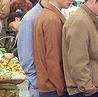
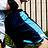
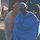
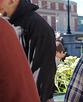
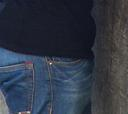
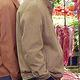
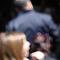
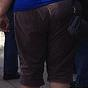
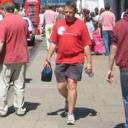
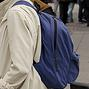
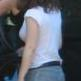
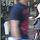
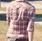
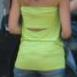
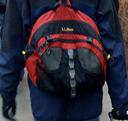
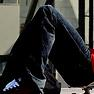
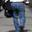
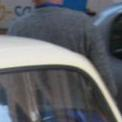
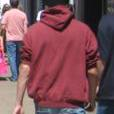

In [15]:
mk.config.DisplayOptions.max_rows = 100

score_dp.lz[out[4].argsort()[-20:]][["object_image", "target", "correlate", "prob"]]

In [22]:
from domino.clip import embed_words
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(4508).load()
words_dp = words_dp.lz[:int(1e4)]

In [23]:
dp = score_dp
attr_emb = dp.lz[(dp["prob"].numpy() > 0.5)]["emb"].data.numpy().mean(axis=0)
#attr_emb = dp.lz[dp["correlate"]== 1]["emb"].data.numpy().mean(axis=0)
ref_emb = dp.lz[dp["target"] == 1]["emb"].data.numpy().mean(axis=0)

scores = np.dot( 
    words_dp["emb"].data.numpy(),   
    (attr_emb - ref_emb) 
)
words_dp.lz[(-scores).argsort()[0:10]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,director,555882,443,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
1,professor,320476,747,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
2,organist,13612,6980,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
3,commanding,43370,3608,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
4,god,198463,1175,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
5,appointment,73147,2559,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
6,professional,533627,458,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
7,architect,113883,1867,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
8,playwright,24496,5038,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
9,cinematographer,10269,8058,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))


In [ ]:
nn.functional.cross_entropy(dp[""])

,object_image (LambdaColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),prob (TensorColumn)
0,,1,0,tensor(1.9250e-08)
1,,1,1,tensor(0.0588)
2,,1,1,tensor(0.1082)
3,,1,0,tensor(0.2666)
4,,1,1,tensor(8.7252e-05)
5,,1,1,tensor(0.3496)
6,,1,1,tensor(0.3849)
7,,1,1,tensor(0.0032)
8,,1,0,tensor(1.0258e-05)
9,,1,1,tensor(9.6029e-07)

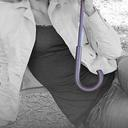
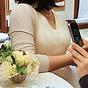
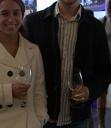
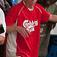
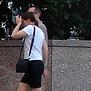
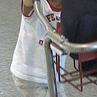
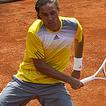
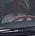
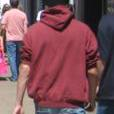
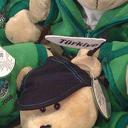
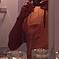
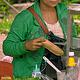
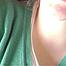
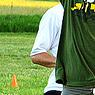
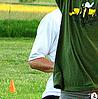
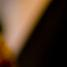
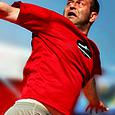
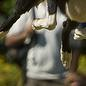
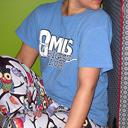
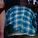
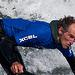
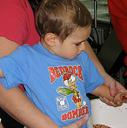
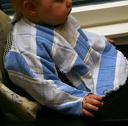
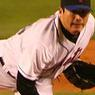
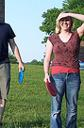
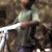
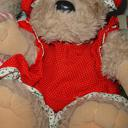
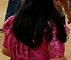
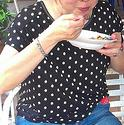
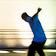
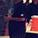
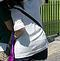
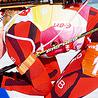
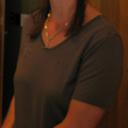
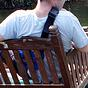
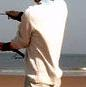
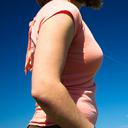
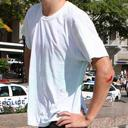
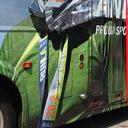
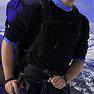
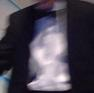
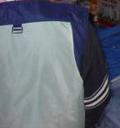
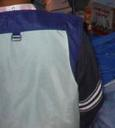
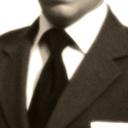
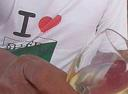
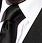
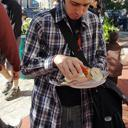
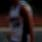

In [28]:
mk.config.DisplayOptions.max_rows = 100
dp.lz[(dp["prob"].numpy() < 0.5) * (dp["target"] == 1)][["object_image", "target", "correlate", "prob"]]

In [96]:
(score_dp["prob"].data.numpy() > 0.001).sum()

99

In [88]:
len(score_dp)

4600

In [54]:
torch.tensor(score_dp["emb"].data, device=0)

<ipython-input-54-02fae554fc7e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(score_dp["emb"].data, device=0)


tensor([[ 0.0390,  0.2744, -0.3843,  ...,  0.3462, -0.1584, -0.1855],
        [ 0.0710,  0.6484, -0.0450,  ...,  1.1016, -0.2976,  0.0517],
        [ 0.1804, -0.1355, -0.5532,  ...,  1.0703, -0.2042, -0.0511],
        ...,
        [ 0.3059,  0.0224, -0.5381,  ...,  0.7358, -0.0623, -0.3462],
        [ 0.0543,  0.0970, -0.0390,  ...,  0.7334,  0.0433, -0.0353],
        [-0.3921,  0.0475,  0.1824,  ...,  1.1406,  0.6475, -0.1752]],
       device='cuda:0', dtype=torch.float16)

In [59]:
from domino.sdm import SpotlightSDM
sdm = SpotlightSDM(config={"emb": "emb"})

sdm.fit(score_dp)

ValueError: only one element tensors can be converted to Python scalars

In [67]:
dp = score_dp
attr_emb = dp.lz[(dp["cluster"] == 2)]["emb"].data.numpy().mean(axis=0)
ref_emb = dp["emb"].data.numpy().mean(axis=0)

scores = np.dot( 
    words_dp["emb"].data.numpy(),   
    (attr_emb - ref_emb) 
)
words_dp.lz[(-scores).argsort()[0:10]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,junior,215680,1092,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
1,umpire,9764,8277,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
2,opponent,46804,3442,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
3,determination,19996,5656,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
4,younger,143054,1567,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
5,coaching,74848,2522,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
6,coach,384927,626,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
7,kemp,8280,8963,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
8,concentration,58600,2941,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
9,sloan,8062,9074,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))


,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn),object_image (LambdaColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),input (LambdaColumn),id (NumpyArrayColumn),split (PandasSeriesColumn),output (ClassificationOutputColumn),prob (TensorColumn),__embed_images_input__ (LambdaColumn),emb (TensorColumn),cluster (NumpyArrayColumn)
0,2398606.0,375.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2398606.jpg,500.0,697488,/home/common/datasets/visual-genome/VG_100K_2/2398606.jpg,,84.0,table,662316.0,table.n.02,499.0,1.0,1.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",662316.0,test,torch.Tensor(shape=torch.Size([2])),tensor(2.6015e-05),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
1,2375491.0,400.0,https://cs.stanford.edu/people/rak248/VG_100K/2375491.jpg,500.0,1268425,/home/common/datasets/visual-genome/VG_100K/2375491.jpg,,26.0,wire,581949.0,wire.n.01,338.0,0.0,154.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",581949.0,test,torch.Tensor(shape=torch.Size([2])),tensor(9.7957e-06),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
2,2377825.0,333.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2377825.jpg,500.0,1180509,/home/common/datasets/visual-genome/VG_100K_2/2377825.jpg,,42.0,street sign,3177814.0,street_sign.n.01,55.0,386.0,86.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",3177814.0,test,torch.Tensor(shape=torch.Size([2])),tensor(0.0001),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
3,2389799.0,500.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2389799.jpg,375.0,896878,/home/common/datasets/visual-genome/VG_100K_2/2389799.jpg,,39.0,sign,1257068.0,sign.n.02,145.0,127.0,185.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",1257068.0,test,torch.Tensor(shape=torch.Size([2])),tensor(0.0004),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
4,2405035.0,357.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2405035.jpg,500.0,537849,/home/common/datasets/visual-genome/VG_100K_2/2405035.jpg,,150.0,wall,1111083.0,wall.n.01,402.0,94.0,205.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",1111083.0,test,torch.Tensor(shape=torch.Size([2])),tensor(2.3699e-05),"LambdaCell(fn=Compose( Resize(size=224, interpolation
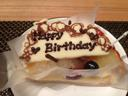
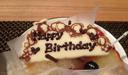
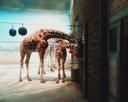
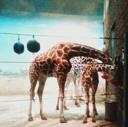
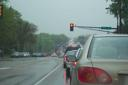
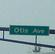
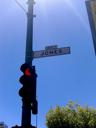
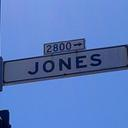
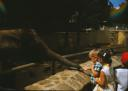
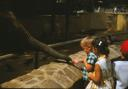
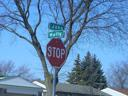
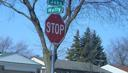
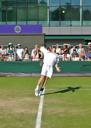
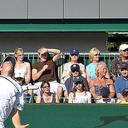
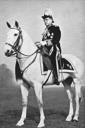
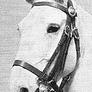
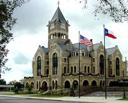
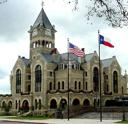
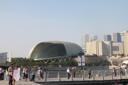
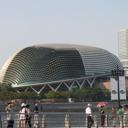

In [68]:
dp.lz[dp["cluster"] == 2]